<a href="https://colab.research.google.com/github/harini1006/Flow-Based-SDN-Intrusion-Detection-System-using-Machine-Learning-with-Real-Time-Alerts/blob/main/sdn2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, r2_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the main dataset
data = pd.read_csv('/content/sdn_intrusion_dataset.csv')

# Display basic information about the dataset
print("Dataset Information:")
print(f"Shape: {data.shape}")
print("\nFirst 5 rows:")
print(data.head())
print("\nColumn names:")
print(data.columns.tolist())
print("\nData types:")
print(data.dtypes)
print("\nMissing values:")
print(data.isnull().sum())
print("\nClass distribution:")
print(data['Label'].value_counts())

Dataset Information:
Shape: (6000, 13)

First 5 rows:
   Flow_Duration  Tot_Fwd_Pkts  Tot_Bwd_Pkts  Fwd_Pkt_Len_Mean  \
0       0.027030          2198             1        417.011235   
1       0.622194            71             0         71.122852   
2       0.939820            41            31         34.930149   
3       0.246326          2035             1        296.313537   
4       0.822615           127             4        121.788601   

   Bwd_Pkt_Len_Mean    Flow_Byts/s   Flow_Pkts/s  Flow_IAT_Mean  \
0     458503.853151  917007.706303  17660.164678       0.000012   
1       5120.845376    5120.845376    394.873627       0.008642   
2         45.845821    1467.066256     49.207255       0.012874   
3     301647.180678  603294.361356   8480.696478       0.000121   
4       3117.788194   15588.940971    343.817413       0.006232   

   Fwd_Header_Len  Bwd_Header_Len  Flow_Flags  Protocol      Label  
0              23              41           4        17        DoS  
1       

In [ ]:
# Make a copy of the original data
df = data.copy()

# Check for any missing values and handle them
print(f"Missing values before handling: {df.isnull().sum().sum()}")

# No missing values in this dataset, so we proceed

# Encode the target variable (Label)
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

# Store the mapping of encoded labels to original labels
label_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print("\nLabel mapping:")
for encoded, original in label_mapping.items():
    print(f"{encoded}: {original}")

# Separate features and target
X = df.drop(columns=['Label'])
y = df['Label']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("\nFeatures after scaling:")
print(X_scaled.head())

Missing values before handling: 0

Label mapping:
0: BENIGN
1: Botnet
2: DDoS
3: DoS
4: PortScan
5: WebAttack

Features after scaling:
   Flow_Duration  Tot_Fwd_Pkts  Tot_Bwd_Pkts  Fwd_Pkt_Len_Mean  \
0      -1.332015      1.068668     -0.636330          0.956852   
1      -0.182558     -0.610716     -0.710651         -0.949951   
2       0.430883     -0.634403      1.593320         -1.149473   
3      -0.908483      0.939971     -0.636330          0.291473   
4       0.204520     -0.566501     -0.413365         -0.670642   

   Bwd_Pkt_Len_Mean  Flow_Byts/s  Flow_Pkts/s  Flow_IAT_Mean  Fwd_Header_Len  \
0          1.809062     2.016354     2.615910      -0.907502       -1.438146   
1         -0.527700    -0.707428    -0.659591      -0.041804        1.183338   
2         -0.553857    -0.718342    -0.725170       0.382820       -1.088615   
3          1.000614     1.079301     0.874418      -0.896603        0.659041   
4         -0.538024    -0.676160    -0.669277      -0.283543       -

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training set class distribution:\n{y_train.value_counts()}")
print(f"Testing set class distribution:\n{y_test.value_counts()}")

Training set shape: (4800, 12)
Testing set shape: (1200, 12)
Training set class distribution:
Label
0    800
5    800
1    800
4    800
2    800
3    800
Name: count, dtype: int64
Testing set class distribution:
Label
3    200
2    200
0    200
1    200
5    200
4    200
Name: count, dtype: int64


In [ ]:
# Initialize the models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average='weighted') * 100
    recall = recall_score(y_test, y_pred, average='weighted') * 100
    r2 = r2_score(y_test, y_pred) * 100

    results[name] = {
        "model": model,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "r2": r2,
        "y_pred": y_pred,
        "y_pred_proba": y_pred_proba
    }

    print(f"{name} - Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}%, Recall: {recall:.2f}%, R2: {r2:.2f}%")


Training Random Forest...
Random Forest - Accuracy: 91.58%, Precision: 91.72%, Recall: 91.58%, R2: 87.69%

Training Support Vector Machine...
Support Vector Machine - Accuracy: 88.83%, Precision: 89.27%, Recall: 88.83%, R2: 79.23%

Training Logistic Regression...
Logistic Regression - Accuracy: 88.75%, Precision: 89.03%, Recall: 88.75%, R2: 76.20%

Training Gradient Boosting...
Gradient Boosting - Accuracy: 90.83%, Precision: 90.98%, Recall: 90.83%, R2: 86.57%


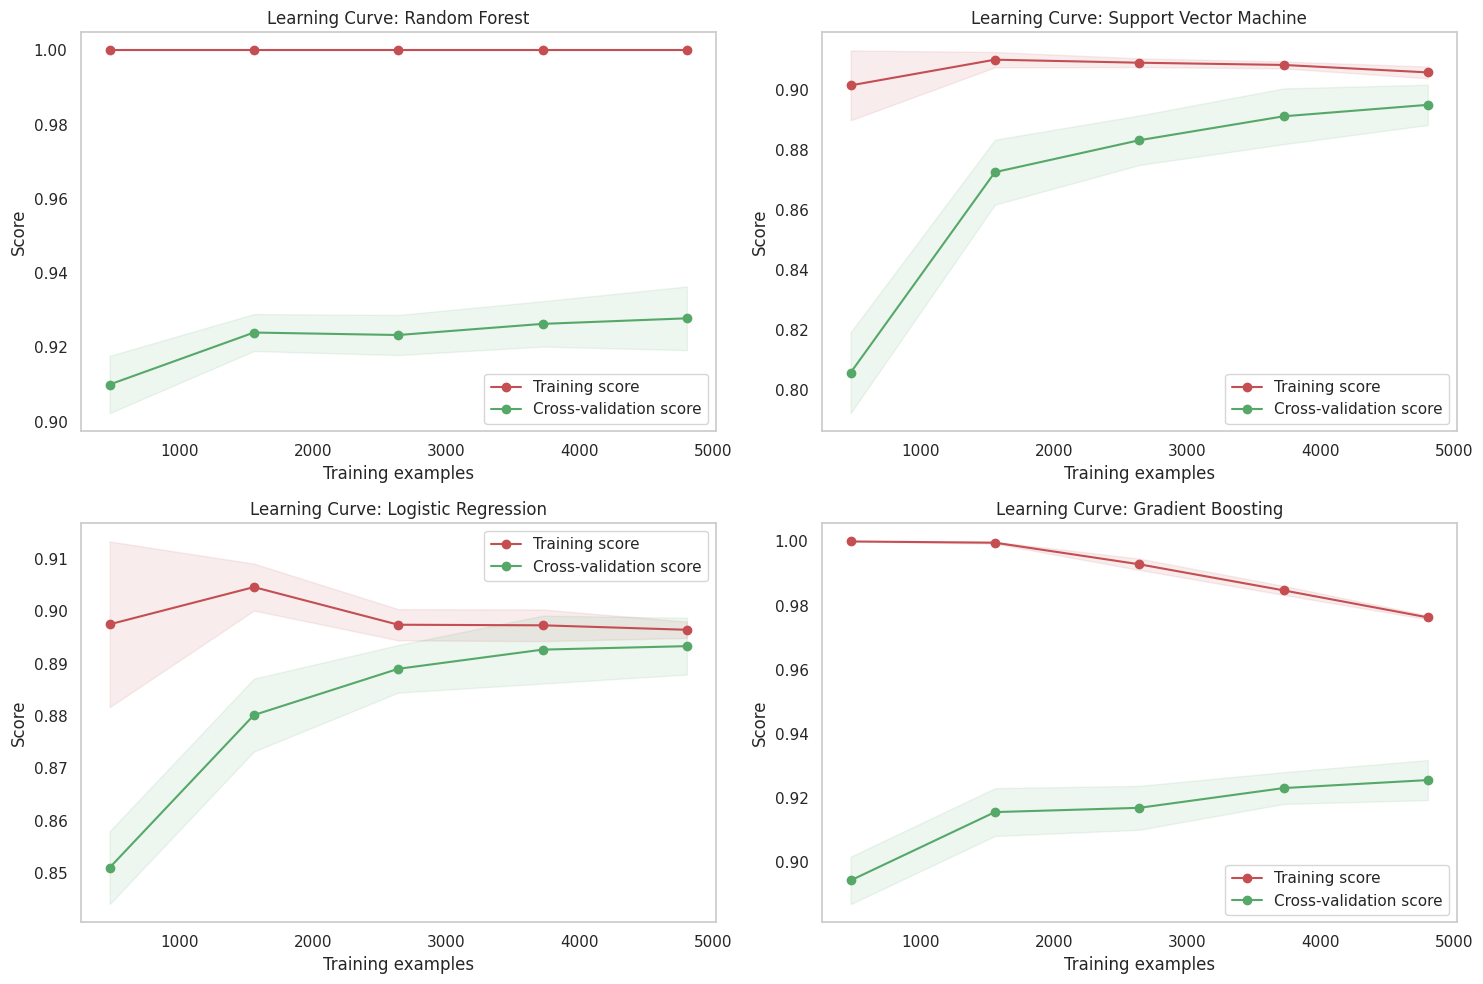

In [ ]:
# Plot learning curves for each model
plt.figure(figsize=(15, 10))

for i, (name, model_info) in enumerate(results.items()):
    model = model_info["model"]

    train_sizes, train_scores, test_scores = learning_curve(
        model, X_scaled, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.subplot(2, 2, i+1)
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
    plt.title(f"Learning Curve: {name}")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()

plt.tight_layout()
plt.show()

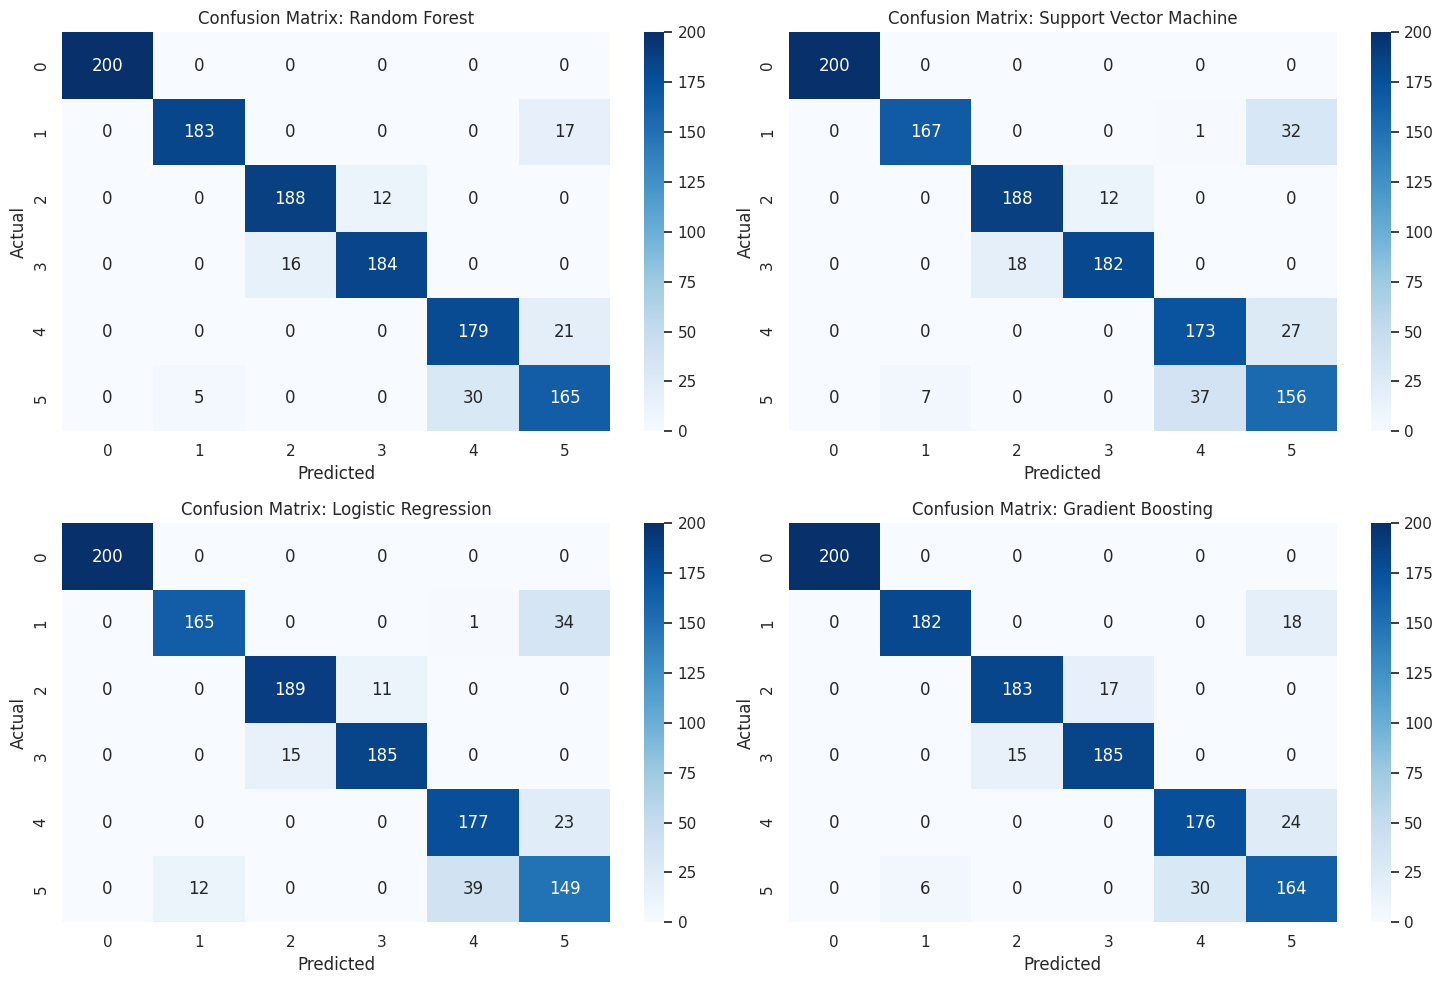

In [ ]:
# Plot confusion matrices for each model
plt.figure(figsize=(15, 10))

for i, (name, model_info) in enumerate(results.items()):
    y_pred = model_info["y_pred"]

    cm = confusion_matrix(y_test, y_pred)

    plt.subplot(2, 2, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()

In [ ]:
# Find the best model based on accuracy
best_model_name = max(results, key=lambda x: results[x]["accuracy"])
best_model = results[best_model_name]["model"]

print(f"\nBest model: {best_model_name} with accuracy: {results[best_model_name]['accuracy']:.2f}%")

# Save the best model, scaler, and label encoder
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("Model, scaler, and label encoder saved successfully!")


Best model: Random Forest with accuracy: 91.58%
Model, scaler, and label encoder saved successfully!


In [ ]:
# Load the saved model, scaler, and label encoder
with open('best_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

with open('scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

with open('label_encoder.pkl', 'rb') as f:
    loaded_le = pickle.load(f)

print("Model, scaler, and label encoder loaded successfully!")

Model, scaler, and label encoder loaded successfully!


In [ ]:
# Create a hardcoded user input (adjust values based on your dataset features)
# This is just an example - adjust the values to match your dataset's features
user_input = np.array([[0.15, 2000, 0, 600, 0, 800000, 12000, 0.0002, 50, 20, 5, 6]])

# Scale the user input
user_input_scaled = loaded_scaler.transform(user_input)

# Make prediction
prediction = loaded_model.predict(user_input_scaled)
prediction_proba = loaded_model.predict_proba(user_input_scaled)

# Get the predicted class name
predicted_class = loaded_le.inverse_transform(prediction)[0]

# Get the confidence
confidence = prediction_proba[0][prediction[0]] * 100

# Get top 3 probable classes
top_3_indices = np.argsort(prediction_proba[0])[-3:][::-1]
top_3_classes = loaded_le.inverse_transform(top_3_indices)
top_3_probabilities = [prediction_proba[0][i] * 100 for i in top_3_indices]

print("\nPrediction for user input:")
print(f"Predicted: \"{predicted_class}\"")
print(f"Confidence: {confidence:.2f}%")
print("Top 3 probable classes:")
for i in range(3):
    print(f"{top_3_classes[i]} ({top_3_probabilities[i]:.2f}%)")


Prediction for user input:
Predicted: "DDoS"
Confidence: 39.00%
Top 3 probable classes:
DDoS (39.00%)
DoS (34.00%)
Botnet (11.00%)


In [ ]:
# Load the sample log data
sample_log = pd.read_csv('/content/sample_log.csv')

print("Sample log data:")
print(sample_log.head())
print(f"\nShape: {sample_log.shape}")
print(f"Columns: {sample_log.columns.tolist()}")

# Check if 'Flow_ID' column exists
if 'Flow_ID' in sample_log.columns:
    flow_ids = sample_log['Flow_ID']
    # Drop the Flow_ID column for prediction
    sample_log_features = sample_log.drop(columns=['Flow_ID'])
    print("\nFlow IDs extracted successfully")
else:
    print("No 'Flow_ID' column found in the sample log data")
    flow_ids = range(1, len(sample_log) + 1)
    sample_log_features = sample_log.copy()

# Ensure the sample log has the same features as the training data
print(f"\nTraining features: {X.columns.tolist()}")
print(f"Sample log features: {sample_log_features.columns.tolist()}")

# Check if features match
if set(X.columns) == set(sample_log_features.columns):
    print("\nFeatures match between training data and sample log")
else:
    print("\nWarning: Features do not match between training data and sample log")
    # Find missing or extra features
    missing_features = set(X.columns) - set(sample_log_features.columns)
    extra_features = set(sample_log_features.columns) - set(X.columns)
    if missing_features:
        print(f"Missing features in sample log: {missing_features}")
    if extra_features:
        print(f"Extra features in sample log: {extra_features}")

Sample log data:
  Flow_ID  Flow_Duration  Tot_Fwd_Pkts  Tot_Bwd_Pkts  Fwd_Pkt_Len_Mean  \
0     id1           1.20            15            20               350   
1     id2           0.15          2000             0               600   
2     id3           0.30          1000             2               580   
3     id4           0.80           150             4               120   
4     id5           0.90            80            10               200   

   Bwd_Pkt_Len_Mean  Flow_Byts/s  Flow_Pkts/s  Flow_IAT_Mean  Fwd_Header_Len  \
0               300         4000           30         0.0200              40   
1                 0       800000        12000         0.0001              50   
2               500       600000         9000         0.0003              60   
3               130         9000          250         0.0030              50   
4               250        16000          400         0.0020              40   

   Bwd_Header_Len  Flow_Flags  Protocol  
0              

In [ ]:
# Scale the sample log data
sample_log_scaled = loaded_scaler.transform(sample_log_features)

# Make predictions
predictions = loaded_model.predict(sample_log_scaled)
predictions_proba = loaded_model.predict_proba(sample_log_scaled)

# Convert predictions to original labels
predicted_classes = loaded_le.inverse_transform(predictions)

# Print predictions for each flow ID
for i, flow_id in enumerate(flow_ids):
    predicted_class = predicted_classes[i]
    confidence = predictions_proba[i][predictions[i]] * 100

    # Get top 3 probable classes
    top_3_indices = np.argsort(predictions_proba[i])[-3:][::-1]
    top_3_classes = loaded_le.inverse_transform(top_3_indices)
    top_3_probabilities = [predictions_proba[i][j] * 100 for j in top_3_indices]

    print(f"\nFlow ID {flow_id}:")
    print(f"Predicted: \"{predicted_class}\"")
    print(f"Confidence: {confidence:.2f}%")
    print("Top 3 probable classes:")
    for j in range(3):
        print(f"{top_3_classes[j]} ({top_3_probabilities[j]:.2f}%)")


Flow ID id1:
Predicted: "BENIGN"
Confidence: 100.00%
Top 3 probable classes:
BENIGN (100.00%)
WebAttack (0.00%)
PortScan (0.00%)

Flow ID id2:
Predicted: "DoS"
Confidence: 45.00%
Top 3 probable classes:
DoS (45.00%)
DDoS (28.00%)
Botnet (12.00%)

Flow ID id3:
Predicted: "DDoS"
Confidence: 79.00%
Top 3 probable classes:
DDoS (79.00%)
WebAttack (10.00%)
Botnet (7.00%)

Flow ID id4:
Predicted: "PortScan"
Confidence: 38.00%
Top 3 probable classes:
PortScan (38.00%)
BENIGN (29.00%)
WebAttack (18.00%)

Flow ID id5:
Predicted: "Botnet"
Confidence: 65.00%
Top 3 probable classes:
Botnet (65.00%)
BENIGN (28.00%)
WebAttack (7.00%)


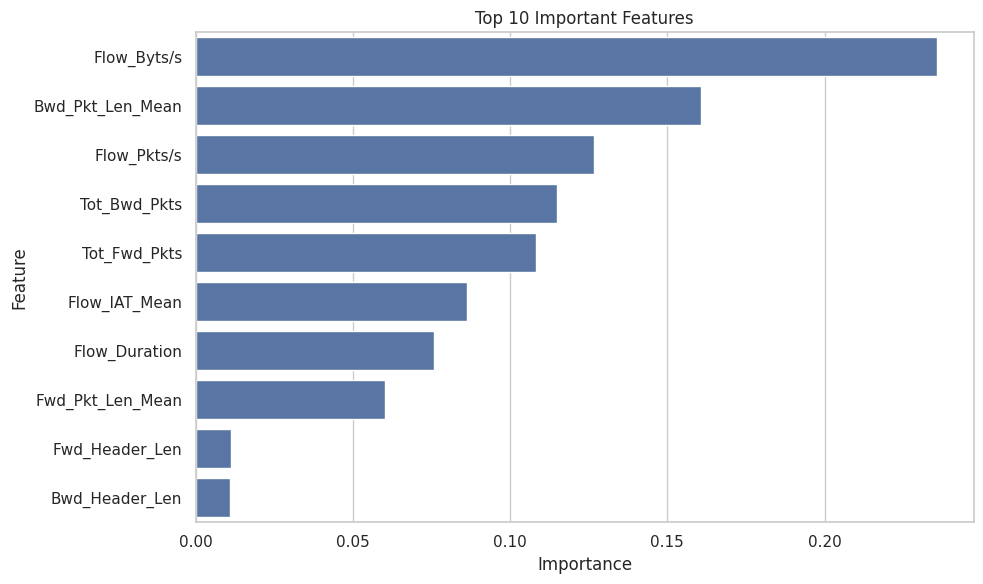


Top 10 Important Features:
            Feature  Importance
5       Flow_Byts/s    0.235724
4  Bwd_Pkt_Len_Mean    0.160759
6       Flow_Pkts/s    0.126815
2      Tot_Bwd_Pkts    0.114839
1      Tot_Fwd_Pkts    0.108398
7     Flow_IAT_Mean    0.086401
0     Flow_Duration    0.075735
3  Fwd_Pkt_Len_Mean    0.060316
8    Fwd_Header_Len    0.011431
9    Bwd_Header_Len    0.011031


In [ ]:
# Feature importance for Random Forest (if it's the best model or for analysis)
if best_model_name == "Random Forest":
    feature_importance = best_model.feature_importances_
    feature_names = X.columns

    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
    plt.title('Top 10 Important Features')
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Important Features:")
    print(importance_df.head(10))

In [ ]:
# Print a summary of the results
print("\n" + "="*50)
print("MODEL PERFORMANCE SUMMARY")
print("="*50)

for name, result in results.items():
    print(f"\n{name}:")
    print(f"  Accuracy: {result['accuracy']:.2f}%")
    print(f"  Precision: {result['precision']:.2f}%")
    print(f"  Recall: {result['recall']:.2f}%")
    print(f"  R2 Score: {result['r2']:.2f}%")

print(f"\nBest Model: {best_model_name}")
print(f"Best Model Accuracy: {results[best_model_name]['accuracy']:.2f}%")

print("\n" + "="*50)
print("PREDICTION SUMMARY")
print("="*50)
print(f"Number of predictions made on sample log: {len(flow_ids)}")
print(f"Classes predicted: {set(predicted_classes)}")


MODEL PERFORMANCE SUMMARY

Random Forest:
  Accuracy: 91.58%
  Precision: 91.72%
  Recall: 91.58%
  R2 Score: 87.69%

Support Vector Machine:
  Accuracy: 88.83%
  Precision: 89.27%
  Recall: 88.83%
  R2 Score: 79.23%

Logistic Regression:
  Accuracy: 88.75%
  Precision: 89.03%
  Recall: 88.75%
  R2 Score: 76.20%

Gradient Boosting:
  Accuracy: 90.83%
  Precision: 90.98%
  Recall: 90.83%
  R2 Score: 86.57%

Best Model: Random Forest
Best Model Accuracy: 91.58%

PREDICTION SUMMARY
Number of predictions made on sample log: 5
Classes predicted: {'Botnet', 'DDoS', 'BENIGN', 'PortScan', 'DoS'}
